In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as cts
import lmfit
plt.style.use('paper')
savefigs = False

### First we put in the infrastructure in place:

First the Hamiltonian

In [2]:
atom = pylcp.atom('23Na')
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*atom.transition[1].k)**2)
print(mass)

7732.850334613172


In [3]:
def return_hamiltonian(Fl, Delta):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, (Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, -Delta*np.eye(He.shape[0])+He, Bgq, Beq, dijq, mass=mass)
    
    return hamiltonian

Next the lasers and the magnetic field:

In [4]:
det = -2.0
beta = 0.5

# Now, make 1D laser beams:
def return_lasers(delta, beta):
    return pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams = return_lasers(0., beta)

magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

hamiltonian = return_hamiltonian(2, det)

### Check some basics:

Make the OBEs:

In [5]:
obe = pylcp.obe(
    laserBeams,
    magField,
    hamiltonian,
    include_mag_forces=False,
    transform_into_re_im=True
)

Next, generate a simple force profile:

In [6]:
v = np.concatenate((np.arange(0.0, 0.1, 0.01),
                    np.arange(0.1, 5.1, 0.1)))

obe.generate_force_profile(
    [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
    [np.zeros(v.shape), np.zeros(v.shape), v],
     name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
     progress_bar=True,
)

Completed in 1:07.                                                  


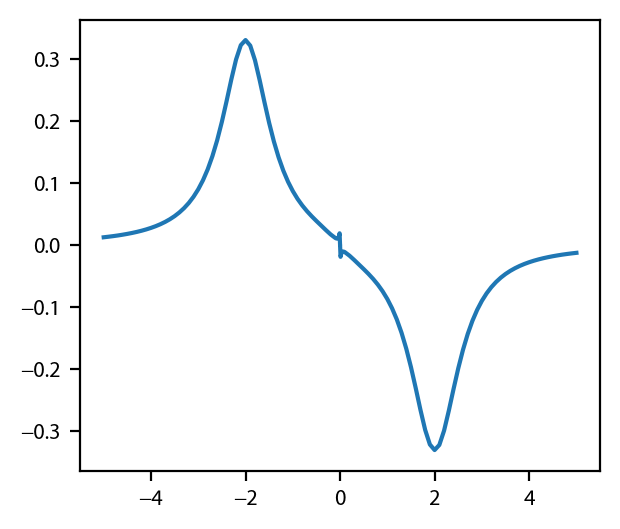

In [7]:
plt.figure()
plt.plot(np.concatenate((-v[::-1], v)),
         np.concatenate((-obe.profile['molasses'].F[2][::-1],
                        obe.profile['molasses'].F[2]))
        )

### Next, we run a test simulation:

In [8]:
tmax = 1e4

obe.set_initial_position(np.array([0., 0., 0.]))
obe.set_initial_velocity(np.array([0., 0., 0.]))
obe.set_initial_rho_equally()

obe.evolve_motion(
    [0, tmax],
    t_eval=np.linspace(0, tmax, 501),
    random_recoil=True,
    progress_bar=True,
    max_scatter_probability=0.5,
    record_force=True,
    freeze_axis=[True, True, False]
)

Completed in 19.35 s.                                               


Plot up the test simulation:

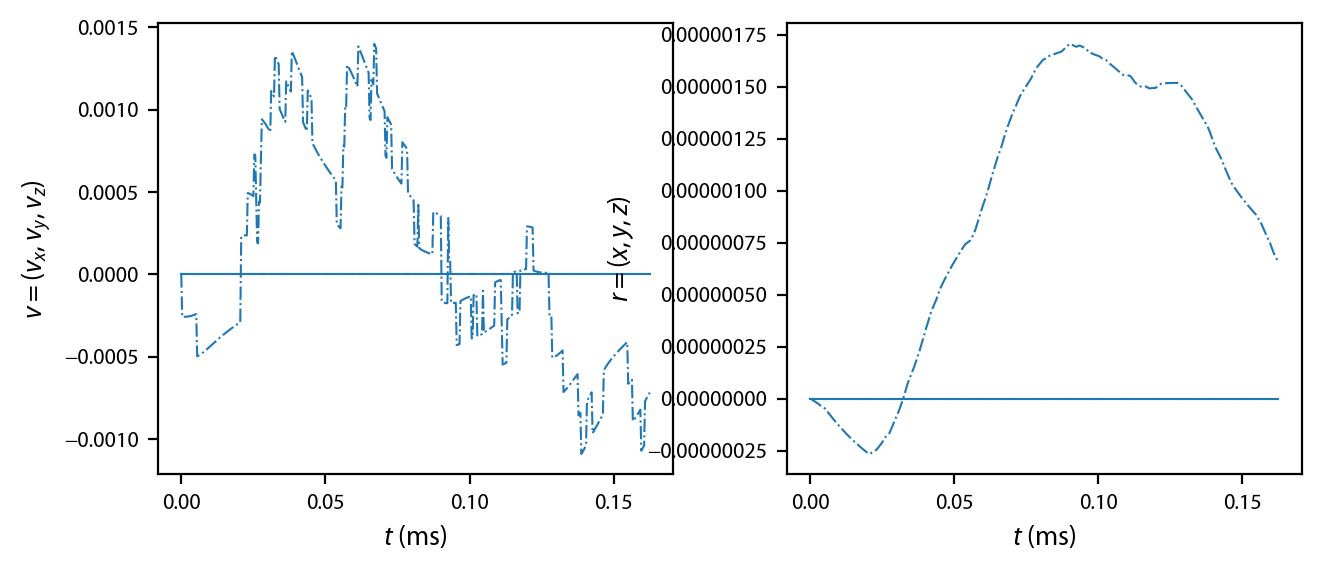

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ll = 0
styles = ['-', '--', '-.']
for jj in range(3):
    ax[0].plot(obe.sol.t*atom.state[2].tau*1e3,
               obe.sol.v[jj], styles[jj],
               color='C%d'%ll, linewidth=0.75)
    ax[1].plot(obe.sol.t*atom.state[2].tau*1e3,
               obe.sol.r[jj]/(100*atom.transition[1].k),
               styles[jj], color='C%d'%ll, linewidth=0.75)

#ax[1].set_ylim(-5., 5.)
ax[0].set_ylabel('$v = (v_x,v_y,v_z)$')
ax[1].set_ylabel('$r = (x,y,z)$')
ax[0].set_xlabel('$t$ (ms)')
ax[1].set_xlabel('$t$ (ms)')
fig.subplots_adjust(left=0.1, wspace=0.22)

Plot up the force experienced by the atom during this short duration of time.

Text(0, 0.5, '$F/(\\hbar k \\Gamma)$')

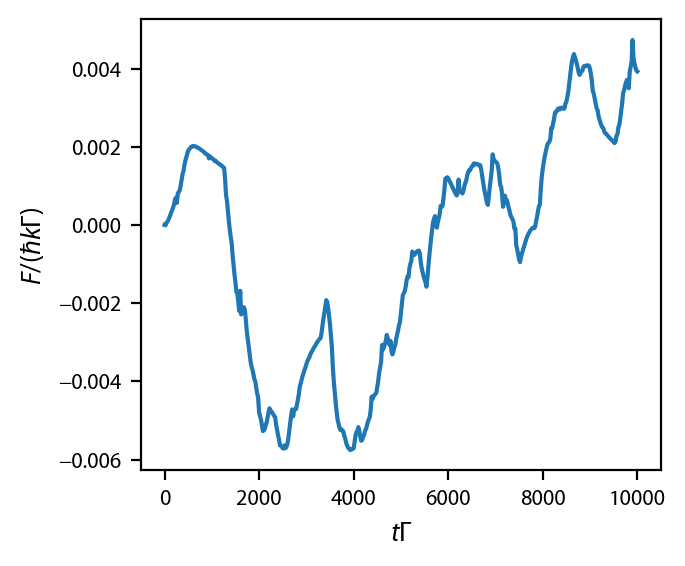

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(obe.sol.t, obe.sol.F[2])
ax.set_xlabel('$t\Gamma$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

### Now run a big yuge sim:

Non-parallel version:
    
```
sols = []
for jj in range(Natoms):
    trap.set_initial_position(np.array([0., 0., 100.]))
    trap.set_initial_velocity(0.0*np.random.randn(3))
    
    trap.evolve_motion([0, 3e2], 
                       t_eval=np.linspace(0, 1e2, 1001),
                       random_recoil=True,
                       recoil_velocity=v_R,
                       progress_bar=True,
                       max_scatter_probability=0.5,
                       record_force=True)
    
    sols.append(copy.copy(trap.sol))
```

In [11]:
import pathos, time

if hasattr(obe, 'sol'):
    del obe.sol
    
t_eval = np.linspace(0, tmax, 5001)

def generate_random_solution(x, tmax=1e5):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    np.random.rand(256*x)
    obe.set_initial_position(np.array([0., 0., 0.]))
    obe.set_initial_velocity(np.array([0., 0., 0.]))
    obe.set_initial_rho_equally()
    obe.evolve_motion(
        [0, tmax],
        t_eval=t_eval,
        random_recoil=True,
        progress_bar=False,
        max_scatter_probability=0.5,
        record_force=True,
        freeze_axis=[True, True, False]
    )
    
    return obe.sol

Natoms = 96
chunksize = 8
sols = []
for jj in range(int(Natoms/chunksize)):
    tic = time.time()
    with pathos.pools.ProcessPool(nodes=8) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    toc = time.time()
    print('completed solutions %d to %d in %.2f s.' % (jj*chunksize, (jj+1)*chunksize, toc-tic))
    

Completed in 7:50.                                                    
Completed in 7:51.                                                    
Completed in 7:51.                                                    
Completed in 7:51.                                                    
Completed in 7:51.                                                    
Completed in 7:51.                                                    
Completed in 7:54.                                                    
Completed in 7:54.                                                    
completed solutions 0 to 8 in 476.19 s.
Completed in 7:43.                                                   
Completed in 7:44.                                                   
Completed in 7:44.                                                   
Completed in 7:45.                                                   
Completed in 7:45.                                                   
Completed in 7:46.                        

Now, plot 'er up:

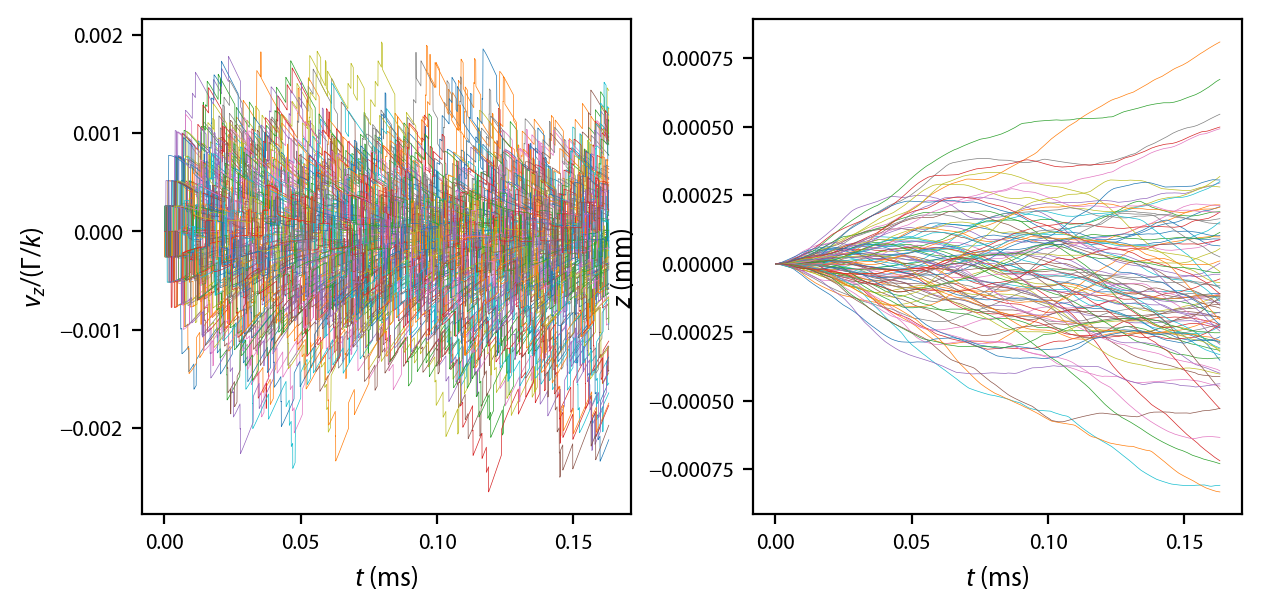

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.75))

for sol in sols:
    ax[0].plot(sol.t*atom.state[1].tau*1e3,
               sol.v[2], linewidth=0.25)
    ax[1].plot(sol.t*atom.state[1].tau*1e3,
               sol.r[2]/(2*np.pi*0.1*atom.transition[1].k), linewidth=0.25)

for ax_i in ax:
    ax_i.set_xlabel('$t$ (ms)')
ax[0].set_ylabel('$v_z/(\Gamma/k)$')
ax[1].set_ylabel('$z$ (mm)')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.25)
if savefigs:
    fig.savefig('random_dynamics_F2_to_F3_molasses.pdf')

One interesting result from the Unager paper is to look at the average force as a function of position and velocity for the random particles.

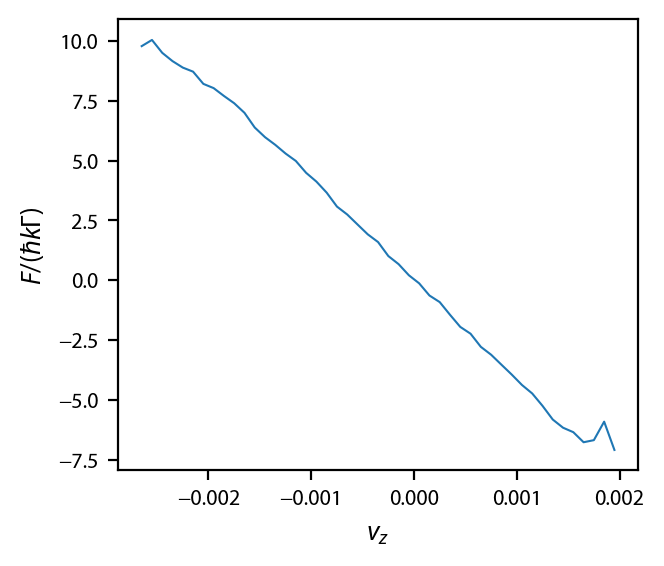

In [13]:
allv = np.concatenate([sol.v.T for sol in sols]).T
allF = np.concatenate([sol.F.T for sol in sols]).T

v = np.arange(-.003, 0.003, 0.0001)
vc = v[:-1]+np.mean(np.diff(v))/2

avgFv = np.zeros((3, 3, vc.size))
stdFv = np.zeros((3, 3, vc.size))

for jj in range(3):
    for ii, (v_l, v_r) in enumerate(zip(v[:-1],v[1:])):
        inds = np.bitwise_and(allv[jj] <= v_r, allv[jj] > v_l)
        if np.sum(inds)>0:
            for kk in range(3):
                avgFv[kk, jj, ii] = np.mean(allF[kk, inds])
                stdFv[kk, jj, ii] = np.std(allF[kk, inds])
        else:
            avgFv[:, jj, ii] = np.nan
            avgFv[:, jj, ii] = np.nan
                          
fig, ax = plt.subplots(1, 1)
ax.plot(vc, 1e3*avgFv[2, 2], linewidth=0.75)
ax.set_xlabel('$v_z$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

if savefigs:
    fig.savefig('forces_experienced_random_evolution_F1_to_F2_obe.pdf')

Let's evaluate the temperature as a function of time:

Temperature 1.63 uK


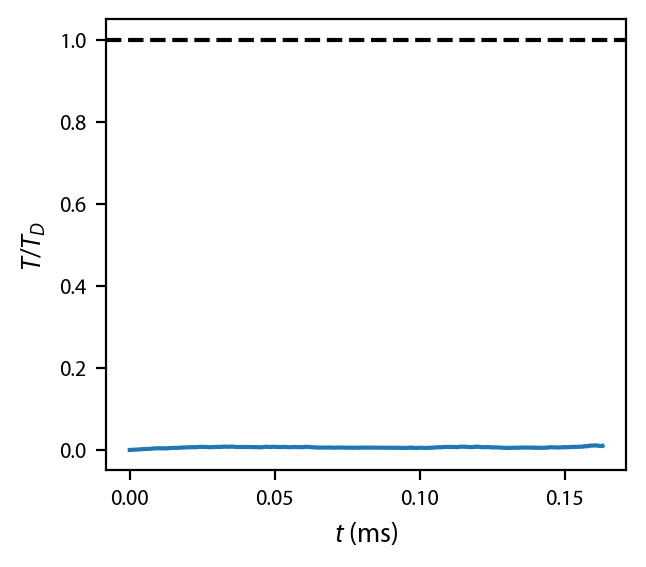

In [16]:
vs = np.nan*np.zeros((3, len(sols), len(t_eval)))
for ii, sol in enumerate(sols):
    vs[:, ii, :] = sol.v
    
sigma_v = np.std(vs[2], axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(t_eval*atom.state[1].tau*1e3, 2*sigma_v.T**2*hamiltonian.mass)
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('$T/T_D$')
ax.set_xlabel('$t$ (ms)')

print('Temperature %.2f uK' % (np.mean(2*sigma_v[-1000:]**2*hamiltonian.mass)*cts.hbar*atom.state[2].gamma/2/cts.k*1e6))